In [1]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import nltk
import textstat
#nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from textstat.textstat import textstat
from matplotlib.table import Table
from scipy.stats import multivariate_normal, invwishart
from abc import ABC, abstractmethod
%matplotlib inline

In [2]:
df = pd.read_csv('raw_dataset - Sheet3.csv')

In [3]:
df

,index,title,author,text,publisher,datepublished,link
0,1,The Marcoses' three-body problem,John Nery,The success of the Marcos-Duterte electoral al...,Rappler,4/1/2024,https://www.rappler.com/voices/thought-leaders...
1,2,State of the opposition: Worth dying for,John Nery,The war on Ninoy Aquino’s legacy is a fight th...,Rappler,8/30/2022,https://www.rappler.com/voices/thought-leaders...
2,3,Elon Musk and magical thinking,John Nery,One of many lessons from the ongoing Twitter f...,Rappler,11/25/2022,https://www.rappler.com/voices/thought-leaders...
3,4,So what's wrong with Marcos's F1 party?,John Nery,Of course we all need to be particular about t...,Rappler,10/06/2022,https://www.rappler.com/voices/thought-leaders...
4,5,Patricia Evangelista and writing the war,John Nery,"In 'Some People Need Killing,' the acclaimed j...",Rappler,10/18/2023,https://www.rappler.com/life-and-style/literat...
5,6,What do we do about Alice Guo,John Nery,The answers she gave in two Senate hearings we...,Rappler,05/29/2024,https://www.rappler.com/voices/thought-leaders...
6,7,The media is not the press,John Nery,Confusing one with the other allows disinforma...,Rappler,04/13/2024,https://www.rappler.com/voices/thought-leaders...
7,8,The paradoxical pope,John Nery,The complicated but lasting legacy of Benedict...,Rappler,01/04/2023,https://www.rappler.com/voices/thought-leaders...
8,9,What's next for VP Sara: Go Macapagal or go Ar...,John Nery,Now that she has passed the point of no return...,Rappler,05/21/2024,https://www.rappler.com/voices/thought-leaders...
9,10,Time to negotiate peace again with the CPP-NPA,John Nery,The communist insurgency is at its weakest. Co...,Rappler,05/11/2024,https://www.rappler.com/voices/thought-leaders...


In [4]:
def preprocess_text(text):
    # Convert to lowercase
    return text.lower()

# Helper function to calculate complex sentence ratio
def count_clauses(sentence):
    # A simple approximation using commas, semicolons, and conjunctions
    return sentence.count(',') + sentence.count(';') + sentence.lower().count('and') + sentence.lower().count('but')

# Feature extraction function
def extract_features(text):
    # Tokenize words and sentences
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    # Basic metrics
    word_count = len([word for word in words if word.isalpha()])
    avg_word_length = np.mean([len(word) for word in words if word.isalpha()]) if word_count > 0 else 0
    avg_sentence_length = word_count / len(sentences) if len(sentences) > 0 else 0

    # Punctuation metrics
    punctuation_count = sum(1 for char in text if char in ['.', ',', ':', ';', '?', '!', '-', '\'', '\"'])
    punctuation_ratio = punctuation_count / word_count if word_count > 0 else 0
    avg_punctuation_per_sentence = punctuation_count / len(sentences) if len(sentences) > 0 else 0

    # Linguistic diversity features
    vocab_size = len(set([word for word in words if word.isalpha()]))
    vocab_ratio = vocab_size / word_count if word_count > 0 else 0

    # Readability metrics
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    gunning_fog = textstat.gunning_fog(text)
    smog_index = textstat.smog_index(text)
    cl_index = textstat.coleman_liau_index(text)

    # Sentence complexity metrics
    total_clauses = sum(count_clauses(sentence) for sentence in sentences)
    avg_clauses_per_sentence = total_clauses / len(sentences) if len(sentences) > 0 else 0
    complex_sentence_ratio = sum(1 for sentence in sentences if count_clauses(sentence) > 1) / len(sentences) if len(sentences) > 0 else 0

    # Lexical density
    pos_tags = pos_tag(words)
    content_words = [word for word, pos in pos_tags if pos.startswith(('NN', 'VB', 'JJ', 'RB'))]
    lexical_density = len(content_words) / word_count if word_count > 0 else 0

    return {
        'word_count': word_count,
        'sentence_count': len(sentences),
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'punctuation_count': punctuation_count,
        'punctuation_ratio': punctuation_ratio,
        'avg_punctuation_per_sentence': avg_punctuation_per_sentence,
        'vocab_size': vocab_size,
        'vocab_ratio': vocab_ratio,
        'flesch_reading_ease': flesch_reading_ease,
        'gunning_fog': gunning_fog,
        'smog_index': smog_index,
        'coleman_liau_index': cl_index,
        'avg_clauses_per_sentence': avg_clauses_per_sentence,
        'complex_sentence_ratio': complex_sentence_ratio,
        'lexical_density': lexical_density
    }

In [5]:
# Apply preprocessing and feature extraction to each text sample
df['preprocessed_text'] = df['text'].apply(preprocess_text)
df_features = df.apply(lambda row: extract_features(row['preprocessed_text']), axis=1).apply(pd.Series)
df = pd.concat([df, df_features], axis=1)

In [6]:
# Model training
X = df[['word_count', 'avg_word_length', 'avg_sentence_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
y = df['author']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [7]:
def classify_new_text(new_text, model):
    # Preprocess the text and extract features
    preprocessed_text = preprocess_text(new_text)
    new_features = extract_features(preprocessed_text)
    new_features_df = pd.DataFrame([new_features])

    # Reindex using the cleaned X_train's columns
    new_features_df = new_features_df.reindex(columns=X_train.columns)

    # Handle any NaN values
    new_features_df = new_features_df.fillna(0)

    # Predict the author
    predicted_author = model.predict(new_features_df)
    return predicted_author[0]

In [8]:
# Function to extract stylometric features for BOCPD
def extract_stylometric_features_for_bocpd(new_text):
    preprocessed_text = preprocess_text(new_text)
    features = extract_features(preprocessed_text)
    return features

In [9]:
# Hazard function
def constant_hazard(lam, t):
    return 1 / lam

# Predictive model (Gaussian)
class MultivariateGaussianPredictiveModel:
    def __init__(self, mu0, kappa0=1, alpha0=1, beta0=None):
        # mu0 is a vector for the mean of the prior
        # beta0 is a matrix for the covariance of the prior
        self.mu0 = np.array(mu0)
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0 if beta0 is not None else np.eye(len(mu0))  # Identity matrix if not provided
        
        # Initialize posterior parameters
        self.mu = np.array(mu0)
        self.kappa = kappa0
        self.alpha = alpha0
        self.beta = np.array(self.beta0)

    def update(self, x):
        x = np.array(x)
        self.kappa += 1
        self.mu = (self.kappa * self.mu0 + x) / (self.kappa + 1)
        diff = x - self.mu0
        self.beta += 0.5 * np.outer(diff, diff)  # Update covariance
        self.alpha += 0.5

    def log_predictive(self, x):
        d = len(self.mu0)  # Dimensionality
        x = np.array(x)

        # Covariance matrix for predictive distribution
        cov_matrix = (self.beta * (self.kappa + 1)) / (self.alpha * self.kappa)
    
        # Regularize the covariance matrix
        cov_matrix += np.eye(d) * 1e-6  # Add small value to diagonal

        try:
            cov_det = np.linalg.det(cov_matrix)
            cov_inv = np.linalg.inv(cov_matrix)

            # Multivariate Gaussian log probability
            log_prob = -0.5 * d * np.log(2 * np.pi) - 0.5 * np.log(cov_det) - \
                       0.5 * np.dot((x - self.mu).T, np.dot(cov_inv, (x - self.mu)))
            return log_prob
        except np.linalg.LinAlgError:
            print("Covariance matrix is singular. Returning -inf for log probability.")
            return -np.inf  # Return a very low log probability

# Bayesian Online Change Point Detection algorithm
def bocpd(data, hazard_func, predictive_model):
    T = len(data)
    P = np.zeros((T+1, T+1))
    P[0, 0] = 1
    
    max_run_length = []
    
    for t in range(1, T+1):
        hazard = hazard_func(t)
        log_pred_prob = np.array([predictive_model.log_predictive(data[t-1]) for _ in range(t)])
        P[t, 1:t+1] = P[t-1, :t] * np.exp(log_pred_prob) * (1 - hazard)
        P[t, 0] = np.sum(P[t-1, :t] * hazard)
        P[t, :t+1] /= np.sum(P[t, :t+1])
        predictive_model.update(data[t-1])
        max_run_length.append(np.argmax(P[t, :t+1]))
    
    return P, max_run_length

# Detect change points
def detect_change_points(run_length_probs):
    change_points = []
    for t, prob in enumerate(run_length_probs):
        if prob == 0:  # Run length resets, indicating a change
            change_points.append(t)
    return change_points


In [10]:
def display_table_with_white_background(dataframe, title):
    # Round numeric values to 2 decimal places
    dataframe = dataframe.round(2)

    fig, ax = plt.subplots(figsize=(12, 4))  # Adjust size as needed
    ax.axis('off')

    table = Table(ax, bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # This will set the default font size for the table

    # Set column width and cell height
    col_width = 1.5
    row_height = 0.4
    num_rows, num_cols = dataframe.shape

    # Add table headers
    for i, column in enumerate(dataframe.columns):
        cell = table.add_cell(0, i, width=col_width, height=row_height, text=column, loc='center', facecolor='white', edgecolor='black')
        cell._text.set_fontsize(12)  # Set font size for header

    # Add table data
    for i, row in dataframe.iterrows():
        for j, value in enumerate(row):
            cell = table.add_cell(i + 1, j, width=col_width, height=row_height, text=f"{value:.2f}" if isinstance(value, (int, float)) else value, loc='center', facecolor='white', edgecolor='black')
            cell._text.set_fontsize(10)  # Set font size for data

    ax.add_table(table)
    plt.title(title, fontsize=14, pad=20)
    plt.show()

In [15]:
def detect_change_points_in_text(new_text, author, trained_model):
    # Preprocess and extract features for the new text
    features = extract_features(preprocess_text(new_text))
    
    features_df = pd.DataFrame([features])
    features_df = features_df[['word_count', 'avg_word_length', 'avg_sentence_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
    
    predicted_author = trained_model.predict(features_df)
    
    if predicted_author[0] != author:
        print(f"Warning: The provided author does not match the predicted author. Using provided author '{author}' for analysis.")
    
    # Extract stylometric features for each sentence
    sentences = sent_tokenize(new_text)
    sentence_features = []
    
    for sentence in sentences:
        preprocessed_sentence = preprocess_text(sentence)
        sentence_feature = extract_features(preprocessed_sentence)
        
        selected_features = [
            sentence_feature['avg_word_length'], 
            sentence_feature['avg_sentence_length'], 
            sentence_feature['punctuation_ratio'], 
            sentence_feature['vocab_ratio'],
            sentence_feature['flesch_reading_ease'],
            sentence_feature['gunning_fog'],
            sentence_feature['smog_index'],
            sentence_feature['coleman_liau_index'],
            sentence_feature['avg_clauses_per_sentence'],
            sentence_feature['complex_sentence_ratio'],
            sentence_feature['lexical_density']
        ]
        sentence_features.append(selected_features)
    
    sentence_features = np.array(sentence_features)
    
    # Initialize BOCPD model for multivariate data
    hazard_func = lambda t: constant_hazard(250, t)
    initial_mean = np.mean(sentence_features, axis=0)
    initial_covariance = np.cov(sentence_features, rowvar=False)  # Initial covariance matrix
    
    predictive_model = MultivariateGaussianPredictiveModel(mu0=initial_mean, beta0=initial_covariance)
    
    # Run BOCPD on all selected features (multivariate analysis)
    P, max_run_length = bocpd(sentence_features, hazard_func, predictive_model)

    # Detect change points
    changepoints = detect_change_points(max_run_length)

    feature_categories = {
        'Phraseology': ['avg_word_length', 'avg_sentence_length', 'avg_clauses_per_sentence'],
        'Punctuation': ['punctuation_ratio'],
        'Linguistic Diversity': ['vocab_ratio', 'lexical_density', 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index', 'complex_sentence_ratio'],
        # 'readability': ['flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index'],
        # 'complexity': ['complex_sentence_ratio']
    }

    explanations = []
    
    # Initialize counters for category changes
    category_changes = {category: 0 for category in feature_categories.keys()}
    total_changes = {category: 0 for category in feature_categories.keys()}
    
    for idx in changepoints:
        if idx > 0 and idx < len(sentences):
            prev_features = sentence_features[idx - 1]
            curr_features = sentence_features[idx]
            
            feature_changes = []
            for i, feature_name in enumerate(
                ['avg_word_length', 'avg_sentence_length', 'punctuation_ratio', 'vocab_ratio',
                 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
                 'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']):
                
                change = curr_features[i] - prev_features[i]
                
                # Only include positive changes
                if change > 0:
                    category = next((cat for cat, features in feature_categories.items() if feature_name in features), None)
                    
                    if category:
                        category_changes[category] += 1
                        total_changes[category] += 1
                        
                        feature_changes.append({
                            'Feature': feature_name,
                            'Change Value': change,
                            'Category': category
                        })
            
            if feature_changes:  # Only add explanations if there are valid positive changes
                explanation = {
                    'sentence': sentences[idx],
                    'feature_changes': feature_changes
                }
                explanations.append(explanation)
    
    # Display results similarly
    for explanation in explanations:
        print(f"Change detected in sentence: {explanation['sentence']}")
        print("Feature changes:")
        
        table_data = []
        for feature_change in explanation['feature_changes']:
            table_data.append([
                feature_change['Feature'],
                feature_change['Change Value'],
                feature_change['Category']
            ])
        
        change_table = pd.DataFrame(table_data, columns=[
            'Feature', 'Change Value', 'Category'
        ])
        display_table_with_white_background(change_table, "Change Point Detection of Features for this Sentence")

    print("\n--- Percentage of Change by Category ---")
    for category, changes in category_changes.items():
        total_sentences = len(sentences)
        category_percentage = (changes / total_sentences) * 100 if total_sentences > 0 else 0
        print(f"{category.capitalize()}: {category_percentage:.2f}% change detected out of {total_sentences} sentences.")

    return changepoints, explanations


Change detected in sentence: However, there are widespread complaints of delayed, insufficient, or inconsistently allocated funds.
Feature changes:


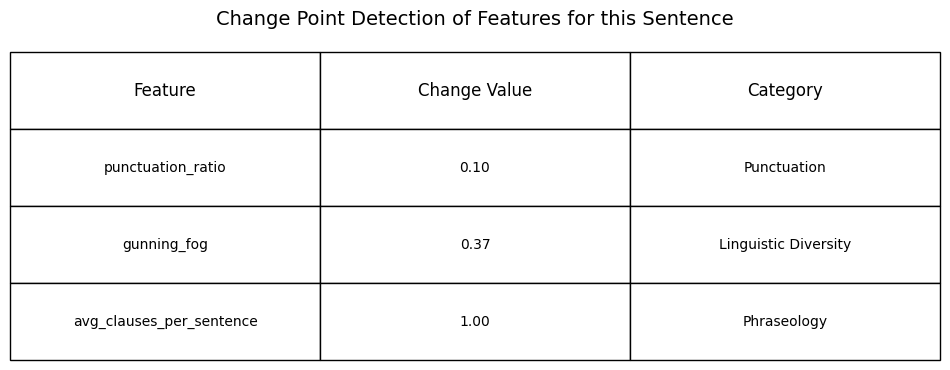

Change detected in sentence: For athletes like Yulo, these incentives are not mere bonuses; they are necessary to fund training, travel, and even basic needs.
Feature changes:


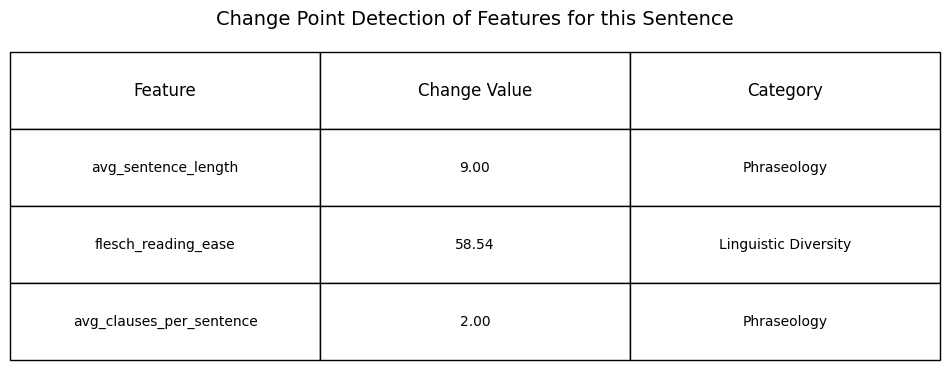

Change detected in sentence: Without timely support, athletes struggle to maintain the high level of performance expected of them, creating a cycle where even the most promising talents are at risk of fading due to lack of resources.
Feature changes:


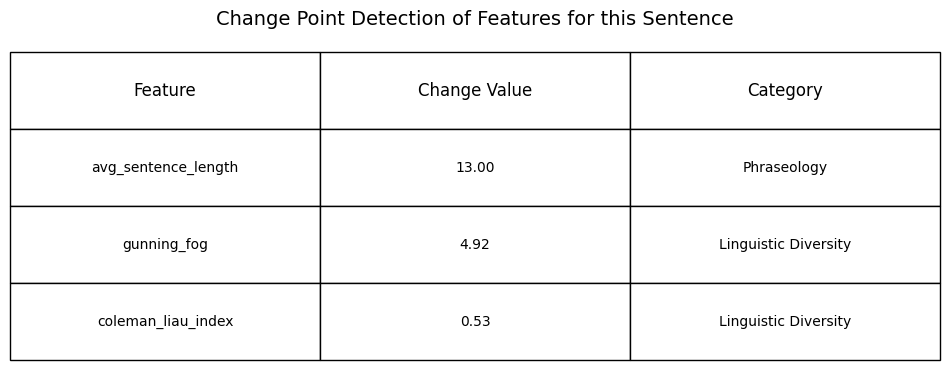

Change detected in sentence: Yulo’s story calls for an urgent examination of how incentives are managed.
Feature changes:


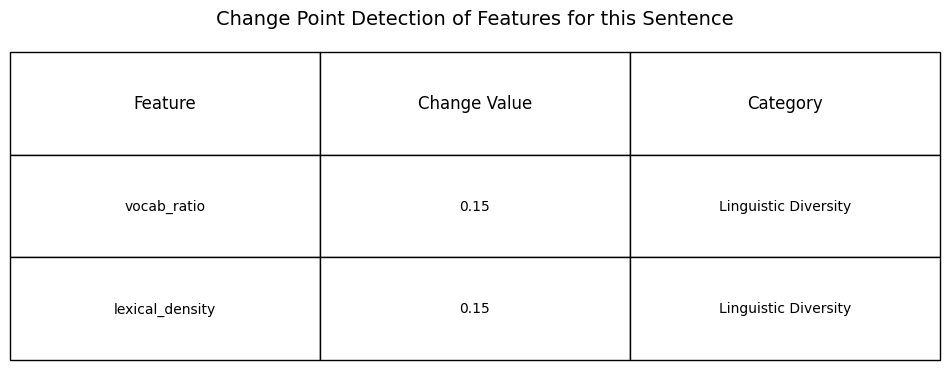

Change detected in sentence: Yulo has expressed frustrations that resonate with many athletes, particularly those in lesser-known sports, where resources are often scarce.
Feature changes:


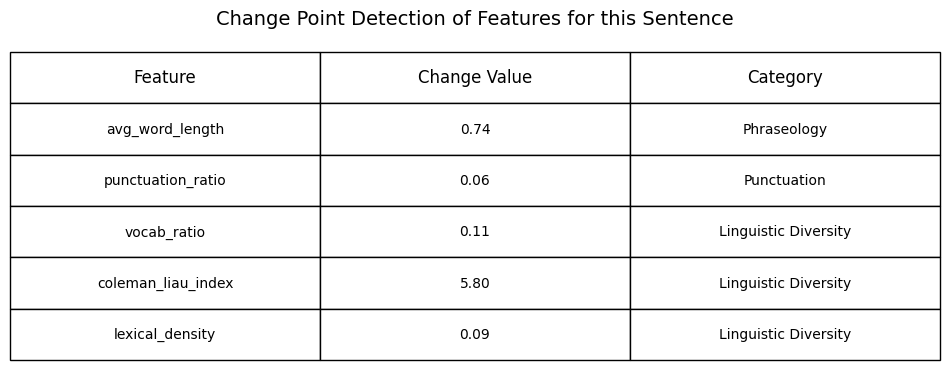

Change detected in sentence: Beyond financial implications, the incentive structure also sends a message about how much the country values these athletes.
Feature changes:


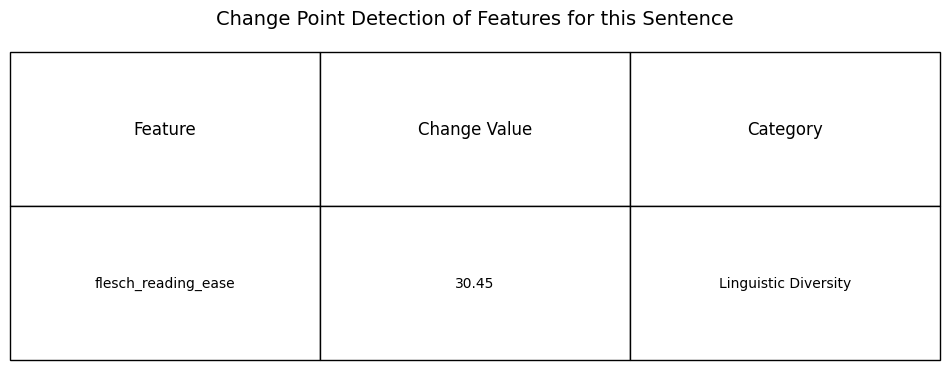

Change detected in sentence: Yulo’s triumphs have brought immense pride, but the lack of support shows a troubling disconnect.
Feature changes:


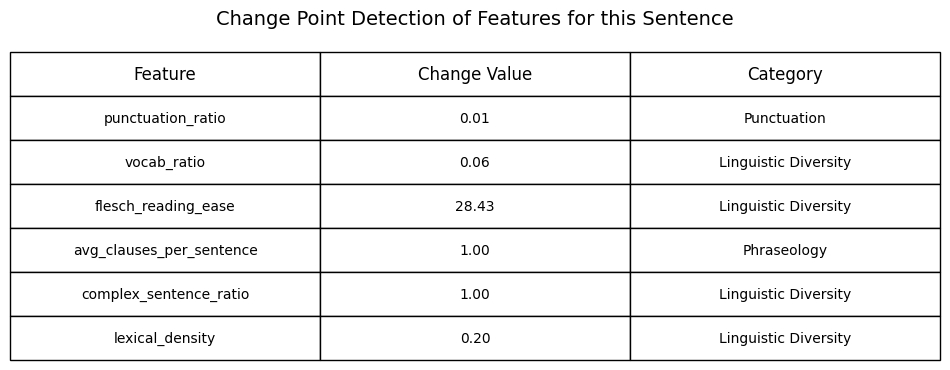

Change detected in sentence: The government’s support—or lack thereof—reflects the priority given to athletics.
Feature changes:


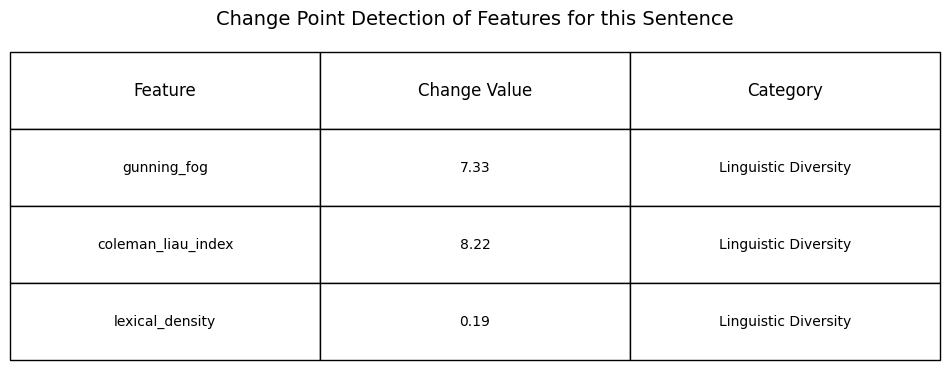

Change detected in sentence: It’s time to invest in a system that not only rewards athletes for their accomplishments but also supports them through the journey that leads to those achievements.
Feature changes:


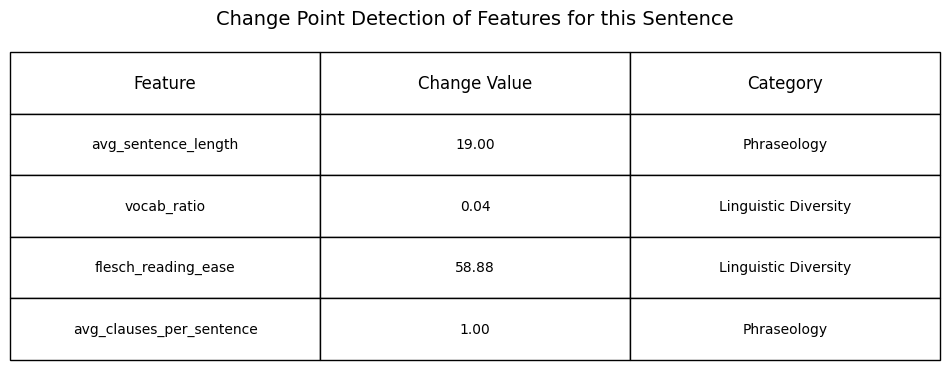

Change detected in sentence: In sum, Carlos Yulo’s case underlines the critical need for reform in Philippine sports funding.
Feature changes:


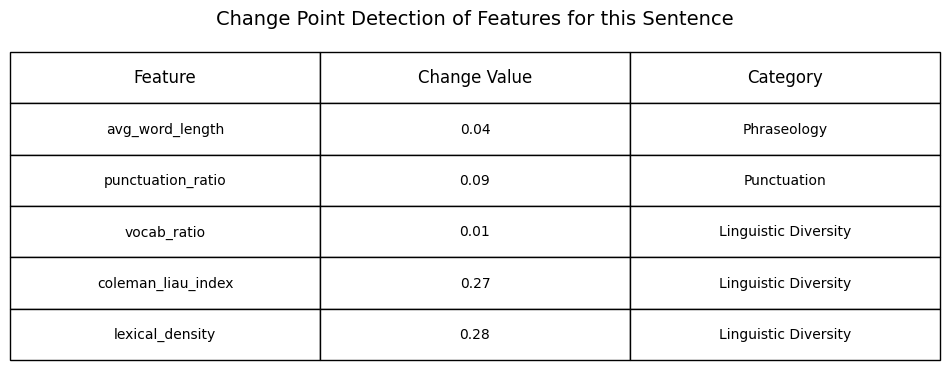


--- Percentage of Change by Category ---
Phraseology: 47.37% change detected out of 19 sentences.
Punctuation: 21.05% change detected out of 19 sentences.
Linguistic diversity: 115.79% change detected out of 19 sentences.


In [21]:
new_text = """Carlos Yulo has emerged as one of the Philippines' most accomplished gymnasts, representing the country on the world stage and clinching several medals in international competitions. However, his journey highlights a major issue in the Philippine sports landscape: the inadequacy of athlete incentives. While his medal wins have undoubtedly bolstered national pride, the lack of consistent financial support and rewards is concerning. The need to re-evaluate the country’s approach to incentivizing athletes is clearer than ever.

The Philippine government, like many others, offers monetary incentives for international sports achievements. However, there are widespread complaints of delayed, insufficient, or inconsistently allocated funds. For athletes like Yulo, these incentives are not mere bonuses; they are necessary to fund training, travel, and even basic needs. Without timely support, athletes struggle to maintain the high level of performance expected of them, creating a cycle where even the most promising talents are at risk of fading due to lack of resources.

Yulo’s story calls for an urgent examination of how incentives are managed. At the core, the question arises: is the current incentive model enough to sustain athletes in such demanding disciplines? Yulo has expressed frustrations that resonate with many athletes, particularly those in lesser-known sports, where resources are often scarce. Unlike basketball or boxing, gymnastics doesn’t receive significant private funding or sponsorships in the Philippines, leaving athletes almost entirely dependent on government support.

Beyond financial implications, the incentive structure also sends a message about how much the country values these athletes. Yulo’s triumphs have brought immense pride, but the lack of support shows a troubling disconnect. The government’s support—or lack thereof—reflects the priority given to athletics. It’s time to invest in a system that not only rewards athletes for their accomplishments but also supports them through the journey that leads to those achievements.

In sum, Carlos Yulo’s case underlines the critical need for reform in Philippine sports funding. We owe it to these athletes to provide a structured, reliable system that not only incentivizes winning but also sustains their pursuit of excellence. As the nation celebrates Yulo’s wins, it must also reflect on the investments needed to ensure the longevity of his—and many others'—athletic careers."""

author = "Diwa C. Guinigundo"
#thresholds = [0.5, 5, 0.02, 0.05, 5, 2, 1, 2]
# predicted_author = classify_new_text(new_text, clf)

# print(f"The predicted author is: {predicted_author}")
changepoints, explanations = detect_change_points_in_text(new_text, author, clf)